In [1199]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import seaborn as sns

# Normalization under a simple generative model 

## (a) 
Stimulating the distribution of number of RNA molecules observed for different genes

In [1233]:
np.random.seed(42)


In [1234]:
p_vec = pd.read_csv('/Users/linlin/Desktop/2023/121/p.tsv',sep='\t',names=['relative_abundance']).astype("float")
p_vec


,relative_abundance
0,0.004201
1,0.000391
2,0.001158
3,0.000052
4,0.000927
...,...
495,0.001054
496,0.000417
497,0.002523
498,0.000523


In this question, we have 500 genes in total. So d = 500.

In [1235]:
sum(p_vec['relative_abundance']) #pretty much sum to 1

0.9999999897096994

In [1236]:
N1 = [15000, 30000, 150000] #sample population size for question 1

In [1237]:
def simulate(N,p_vec):
    """
    INPUT: 
        N, list of length n, sample sizes
        p_vec: list of length d, true relative abundances of genes
    OUTPUT: 
        simu: matrix of size n x d, where simu[i][j] corresponds to number of 
            molecules of i genes in sampe j
    """
    simu = pd.DataFrame()
    for n in range(len(N)):
        abundances = np.random.multinomial(N[n], p_vec['relative_abundance'])
        simu[str(n)] = abundances
    return simu
 

    

In [1238]:
simu = simulate(N1,p_vec)
print(simu.head())

    0    1    2
0  61  132  634
1   7   11   52
2  18   32  172
3   0    3   13
4  10   15  132


In [1239]:
def plot_simulate(simu, x_idx, y_idx, N):
    """
    INPUT:
        simu: simulation matrix from above, 
        x_idx, y_idx: the two samples to be plotted in a scatterplot
        N: list of sample sizes
    OUTPUT: 
        plot a scatterplot of x_idx sample v.s. y_idx sample
    """
    plt.scatter(x = simu.iloc[:,x_idx], y = simu.iloc[:,y_idx],s=2)
    plt.xlabel('n = '+str(N[x_idx]))
    plt.ylabel('n = '+str(N[y_idx]))
    plt.title("raw counts of n = "+str(N[y_idx])+" v.s. "+str(N[x_idx]))
    ax = plt.gca()
    yaxmin,yaxmax = ax.get_ylim()
    xaxmin,xaxmax = ax.get_xlim()
    axmin = min(xaxmin,yaxmin)
    axmax = max(xaxmax,yaxmax)
    ax.set_ylim(axmin,axmax)
    ax.set_xlim(axmin,axmax)
    ax.set_aspect('equal')
    

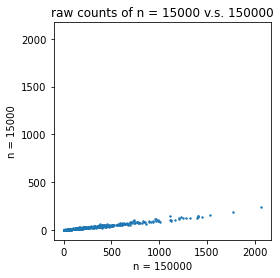

In [1240]:
plot_simulate(simu,2,0,N1)

# (b) 


In [1241]:
def DESeq_norm(mat):
    #x-jg, number of molecules of gene g in sample j
    """
    IMPLEMENTATION OF DESeq_style normalization
    INPUT:
        mat: matrix of dimension n (#of samples) x d (#of genes) 
            where mat[j][g] is the #of molecules of gene g in sample j
    OUTPUT:
        s_mat: matrix of dimension n x d 
        sample_specific_norm_fac: 
    """
    #filter out rows with zeros
    try:
        out = [list((mat == 0).all()).index(True)]
        [mat.drop(d, axis=1, inplace=True) for d in out]
    except ValueError:
         #none to drop
         pass

    (n_sample,gene_cnt) = mat.shape
    mat.columns = list(range(0,gene_cnt))
    s_mat = mat
    for g in range(gene_cnt):
            denominator = (np.sum([mat.iloc[k,g] for k in range(n_sample)])) ** (1/n_sample)
            for j in range(n_sample):
                if denominator != 0:
                    s_mat.iloc[j,g] = mat.iloc[j,g] / denominator
    
    norm_fac = list(s_mat.apply(np.median,axis=1))

    return s_mat, norm_fac

In [1245]:
s_mat, norm_fac = DESeq_norm(simu.T)
s_mat.head()

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
0,6.498723,1.698499,2.972726,0.000000,1.853674,0.510873,10.168295,2.999796,0.000000,9.211896,...,3.698684,6.453880,3.105939,3.225395,5.115118,2.131088,0.708245,3.683478,2.215155,3.778036
1,14.062810,2.669070,5.284846,1.190551,2.780512,2.043492,17.933174,6.528969,0.436790,14.880756,...,6.575438,12.907760,5.901284,7.218742,7.941894,6.721124,2.832979,10.542368,4.430309,9.515055
2,67.544100,12.617423,28.406046,5.159053,24.468502,12.771824,88.926357,22.586703,4.804693,73.492712,...,43.014325,64.210637,32.457062,31.946771,42.132418,28.359864,14.400977,47.758195,13.733959,37.780364


In [1246]:
norm_fac

[3.225395190674459, 6.166207596789803, 31.557278251706972]

In [1247]:
s_mat.T.melt(id_vars=None, var_name='no. sample', value_name='# of genes')

,no. sample,# of genes
0,0,6.498723
1,0,1.698499
2,0,2.972726
3,0,0.000000
4,0,1.853674
...,...,...
1492,2,28.359864
1493,2,14.400977
1494,2,47.758195
1495,2,13.733959


# (c) 

In [1248]:

def plot_s_hist(s_mat,idx,N):
    """
        make histograms of s_jg values for sample with list of indices
        also scatterplots
    """

    dat = s_mat.T.melt(id_vars=None, var_name='no. sample', value_name='s values')
    dat = dat[dat["no. sample"].isin(idx)]
    sns.displot(
        dat, x="s values", col="no. sample",kind = 'hist',
        facet_kws=dict(margin_titles=True),
        bins = 50
    )
    pop_size = [N[int(i)] for i in idx]
    plt.gcf().set_size_inches(10,5)
    plt.suptitle("S values distribution.\n Respective sample size: "+str(pop_size))
    plt.tight_layout()


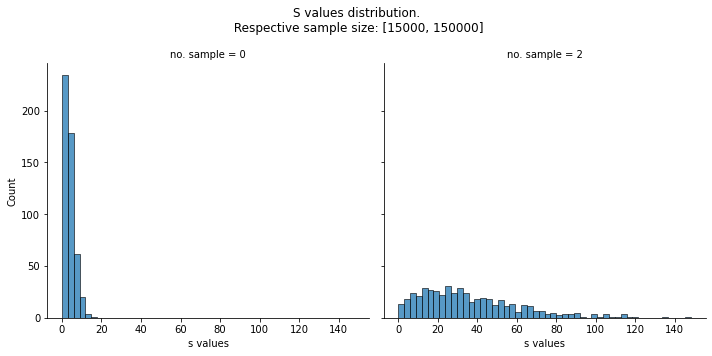

In [1249]:
plot_s_hist(s_mat,['0','2'],N1)

The normalizer/s - values distribution of the first sample (n=15,000) is much more right-skewed than the last sample (n=150,000). The distributions of the normalizer values are reflective of the sample sizes —— smaller sample has overall smaller normalizers, vice versa. Thus, if we divide gene counts by the s-values, we could normalize our observations based on size factors. 

In [1255]:

def s_scatt(mat, x_idx,y_idx,N):
    fig, ax = plt.subplots()
    ax.scatter(y = mat.iloc[y_idx,:],x = mat.iloc[x_idx,:], s=2)
    plt.xlabel('n = '+str(N[x_idx]))
    plt.ylabel('n = '+str(N[y_idx]))
    plt.title("normalizer/s of samples of size n = "+str(N[y_idx])+' v.s. '+str(N[x_idx]))
    
    yaxmin,yaxmax = ax.get_ylim()
    xaxmin,xaxmax = ax.get_xlim()
    axmin = min(xaxmin,yaxmin)
    axmax = max(xaxmax,yaxmax)
    ax.set_ylim(axmin,axmax)
    ax.set_xlim(axmin,axmax)
    ax.set_aspect('equal')
    #plt.gcf().set_size_inches(5,5)
    

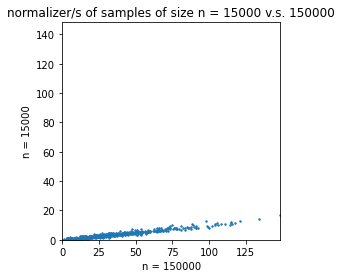

In [1271]:
s_scatt(s_mat, 2,0,N1)

Such trend is also evident in the scatter plot, where for the same gene (a point), the s-value/size factor is almost one order of magnitude lower in the sample with a size of 15,000 than in the sample with a size of 150,000.

In [1257]:
print(norm_fac)

[3.225395190674459, 6.166207596789803, 31.557278251706972]


The sample-specific normalization factor of the larger sample is about 10 times the larger sample, proportional to their sample sizes. 

# (d) 

In [1258]:
def s_norm(mat, norm_fac):
    norm_mat = mat
    for i in range(len(norm_fac)):
        norm_mat.iloc[i,:] = mat.iloc[i,:].div(norm_fac[i])
    return norm_mat

Text(0.5, 1.0, '')

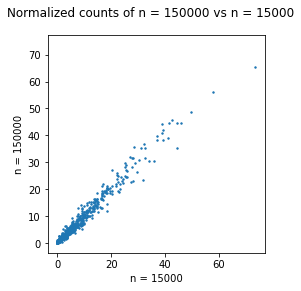

In [1273]:
norm_mat = s_norm(simu.T,norm_fac)
plot_simulate(norm_mat.T,0,2,N1)
plt.suptitle("Normalized counts of n = 150000 vs n = 15000")
plt.title("")

Comparing to the scatterplot of raw counts from question one, the points are now pretty much aligned to the y=x line because the counts are size-normalized. 

# (e) 

In [1260]:
N2 = [1e6,1e6,1e6]
simu_e = simulate(N2,p_vec)


In [1261]:
s_mat_e, norm_fac_e = DESeq_norm(simu_e.T)

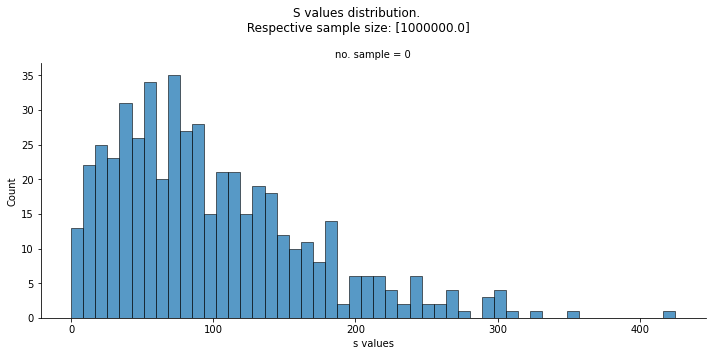

In [1262]:
plot_s_hist(s_mat_e,['0'],N2)

In [1263]:
print(norm_fac_e)

[83.70973369020427, 84.32447114699472, 83.39977810108644]


The results are intuitive. The sample size increases by almost an order of magnitude; the sample specific normalization factor n double, and there is an overall increase in s values. 

# (f) 

In [1264]:
q_vec = pd.read_csv('/Users/linlin/Desktop/2023/121/q.tsv',sep='\t',names=['relative_abundance']).astype("float")
q_vec

,relative_abundance
0,0.041182
1,0.003831
2,0.011349
3,0.000509
4,0.009084
...,...
495,0.000646
496,0.000256
497,0.001546
498,0.000321


In [1265]:
N2 = [1e6,1e6,1e6]
simu_q = simulate(N2,q_vec)
s_mat_q, norm_fac_q = DESeq_norm(simu_q.T)


[71.51345973677954, 72.46832254772266, 71.7481397837766]


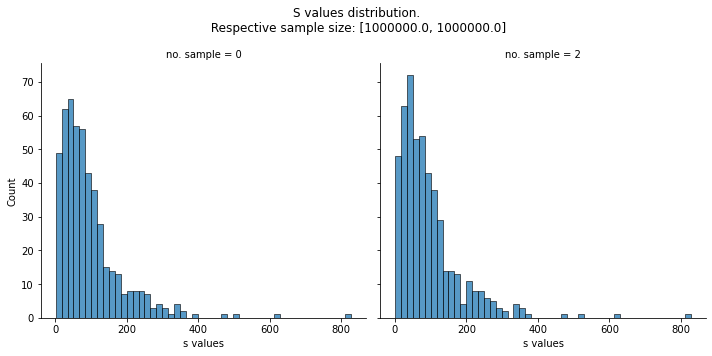

In [1266]:
plot_s_hist(s_mat_q,['0','2'],N2)
print(norm_fac_q)

The distribution of s values is more right-skewed when the abundances come from the q.tsv file. The sample specific normalization factors are very similar for the three samples simulated under the q abundances, but smaller than those simulated under the p abundances, given the same sample size = 1e6. 

# (g)

In [1267]:
simu_combo = pd.concat([simu_e,simu_q],axis=1)
simu_combo.columns = range(6)
simu_combo

,0,1,2,3,4,5
0,4177,4243,4160,41272,41438,41220
1,382,398,364,3826,3885,3895
2,1194,1182,1155,11247,11403,11320
3,48,49,57,512,537,515
4,947,902,951,9101,9085,8923
...,...,...,...,...,...,...
495,1042,1031,1092,650,635,620
496,405,420,396,249,269,241
497,2588,2601,2528,1501,1584,1569
498,582,494,542,295,336,310


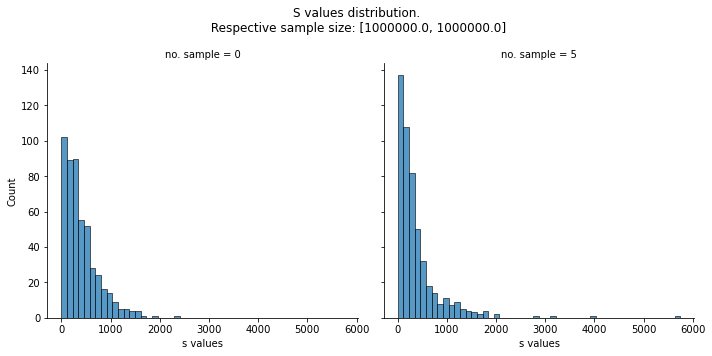

In [1280]:
N = [1e6,1e6,1e6,1e6,1e6,1e6]
s_mat_combo, norm_fac_combo = DESeq_norm(simu_combo.T)
plot_s_hist(s_mat_combo,[0,5],N)

Text(0, 0.5, 'sample 5 (q_vec)')

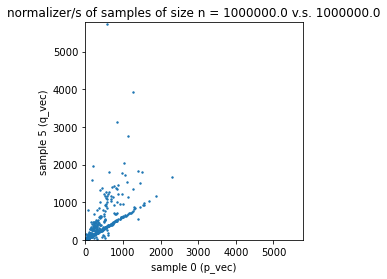

In [1274]:
s_scatt(s_mat_combo,0,5,N)
ax = plt.gca()
ax.set_xlabel('sample 0 (p_vec)')
ax.set_ylabel('sample 5 (q_vec)')


In [1281]:
print("normalization factors from p vec: "+str(norm_fac_e))
print("normalization factors from q vec: "+str(norm_fac_q))
print("normalization factors from combining p and q vec: "+str(norm_fac_combo))

normalization factors from p vec: [83.70973369020427, 84.32447114699472, 83.39977810108644]
normalization factors from q vec: [71.51345973677954, 72.46832254772266, 71.7481397837766]
normalization factors from combining p and q vec: [305.16844921537984, 307.291660032933, 304.80696672799706, 234.7027982327357, 237.68834419672658, 236.2897844417716]


The sample specific normalization factors increase drastically for the combined data, which contains samples generated under different gene abundances distributions

Text(0.5, 0.98, 'number of genes with certain abundances in the two samples')

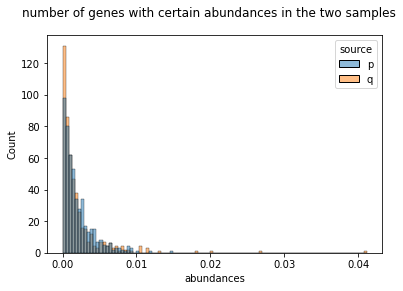

In [1284]:
vec_c = pd.concat([p_vec,q_vec],axis=1)
vec_c.columns=['p','q']
v = vec_c.melt(id_vars = None,value_name='abundances',var_name = 'source')
sns.histplot(data=v,x='abundances',hue='source')
plt.suptitle("number of genes with certain abundances in the two samples")

From the histograms that visualize the distributions of gene abundances, it's evident that the q distribution has significant outliers widh abundances above 0.03 in comparison to the p distribution, but is overall more right-skewed, so the raw counts of more genes are smaller for the q samples except for one or two that have significantly higher counts. 

Translating to scenarios of finding differentially expressed genes among different samples, the 'outliers' in the q sample are genes that are very differentially expressed between q and p. However, these few genes take up quite a large part of the total compositio and subsequently squeeze the counts of all other genes. The DESeq normalization would take this into account. 

But because the DESeq style normalization uses the median of the ratios of observed counts to calculate size factors, it's pretty robust to outliers and would give a larger sample-specific normalization factor to the p sample, who has a majority of genes with slightly higher abundances than their counterparts in q sample. As the sample size gets larger, a slight difference in abundance would become a large difference in raw counts, which translates to a large difference in the sample-specific normalization factor. 

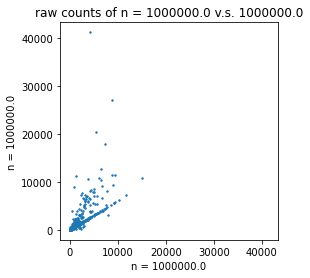

In [1285]:
plot_simulate(simu_combo,0,5,N)

Text(0, 0.5, 'sample from q')

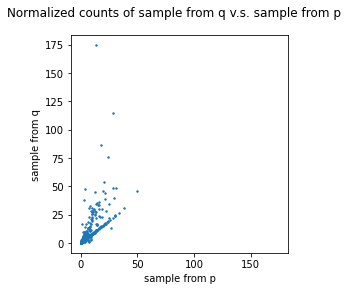

In [1286]:
combo_norm = s_norm(simu_combo.T, norm_fac_combo)
plot_simulate(combo_norm.T,0,5,N)
plt.suptitle("Normalized counts of sample from q v.s. sample from p")
plt.title("")
plt.xlabel("sample from p")
plt.ylabel("sample from q")

# Coloring differently expressed genes  

In [1298]:
colors = ['orange' for i in range(int(round(500 * 0.4)))] + ['blue' for i in range(int(500 - round(500 * 0.4)))]


In [1323]:

def colr(mat, x_idx,y_idx,N,des,ax):
    ax.scatter(y = mat.iloc[y_idx,:],x = mat.iloc[x_idx,:], s=2,color=colors)
    ax.set_title("differently expressed genes between q and p "+des)
    
    yaxmin,yaxmax = ax.get_ylim()
    xaxmin,xaxmax = ax.get_xlim()
    axmin = min(xaxmin,yaxmin)
    axmax = max(xaxmax,yaxmax)
    ax.set_ylim(axmin,axmax)
    ax.set_xlim(axmin,axmax)
    ax.set_aspect('equal')
    ax.set_xlabel('sample 0 (p_vec)')
    ax.set_ylabel('sample 5 (q_vec)')
    ax.axline([0, 0], [1, 1])

    #plt.gcf().set_size_inches(5,5)
    

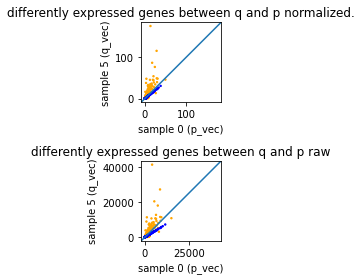

In [1326]:
_,ax=plt.subplots(2)
colr(combo_norm,0,5,N,'normalized.',ax[0])

colr(simu_combo.T,0,5,N,'raw',ax[1])
plt.tight_layout()


The differentially expressed genes are those that fall off the y=x line and in the normalized version the non-differentially expressed genes adhere to the y=x line more due to normalization. 